## libraries

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# custom preprocessing libraries
from preprocessing import *

# sklearn libraries
from sklearn import svm
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn import metrics

Matplotlib created a temporary cache directory at C:\Users\madio\AppData\Local\Temp\matplotlib-qty7k___ because the default path (C:\Users\madio\.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


import warnings
warnings.filterwarnings('ignore')

## load data

In [2]:
# load preprocessed data
df_complete = pd.read_csv('../data/final_large_dataset_complete_15-06-2024.csv', low_memory = False)

df_0_900 = pd.read_csv('../data/final_large_dataset_0_900_15-06-2024.csv', low_memory = False)
df_900_2000 = pd.read_csv('../data/final_large_dataset_900_2000_15-06-2024.csv', low_memory = False)
df_2000_2500 = pd.read_csv('../data/final_large_dataset_2000_2500_15-06-2024.csv', low_memory = False)

## Visualisations

### General distribition

Text(0.5, 1.0, 'Distribution of planned turnover-times with categorisation (without outliers)')

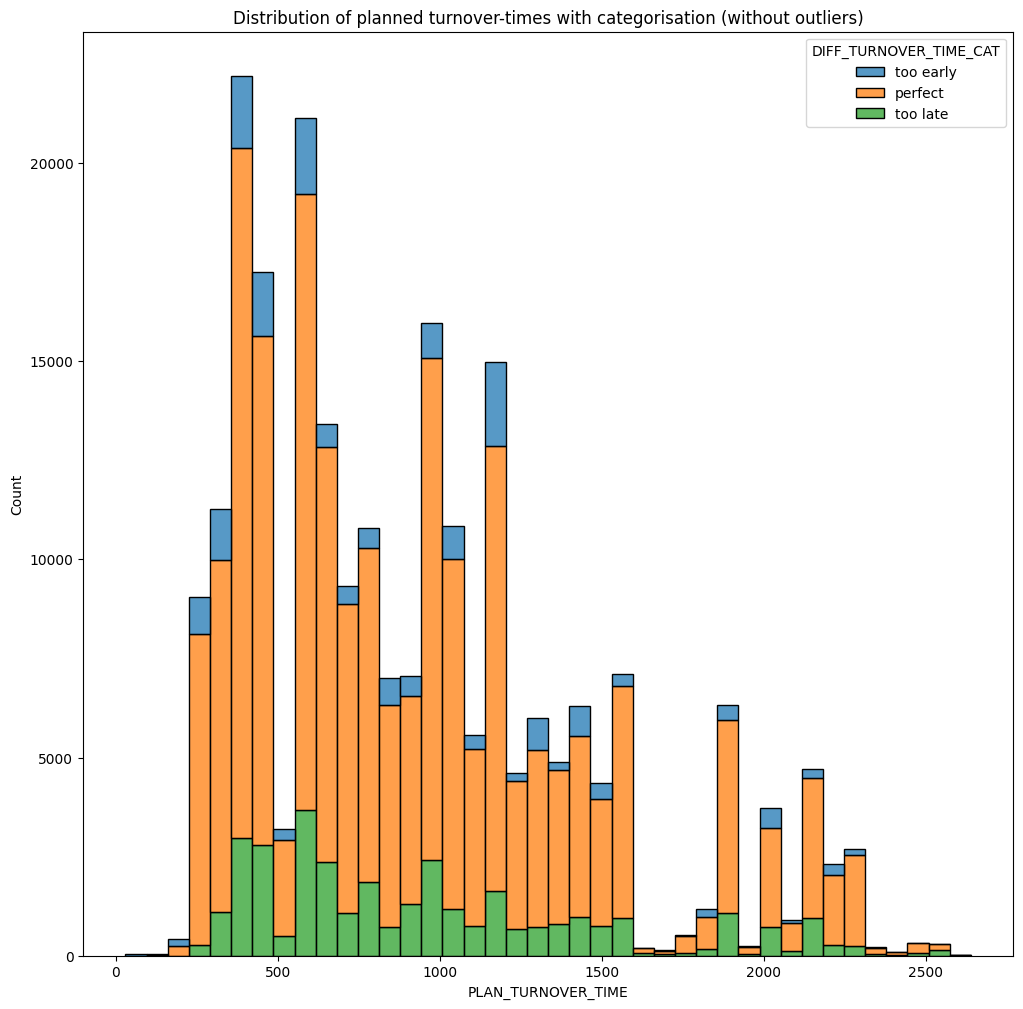

In [6]:
# plot the distribution of the difference in turnover time
hue_order = ['too early', 'perfect', 'too late']

plt.figure(figsize=(12, 12))
sns.histplot(df_complete, x = 'PLAN_TURNOVER_TIME', hue = 'DIFF_TURNOVER_TIME_CAT', hue_order = hue_order ,bins=40, multiple='stack')
plt.title("Distribution of planned turnover-times with categorisation (without outliers)")

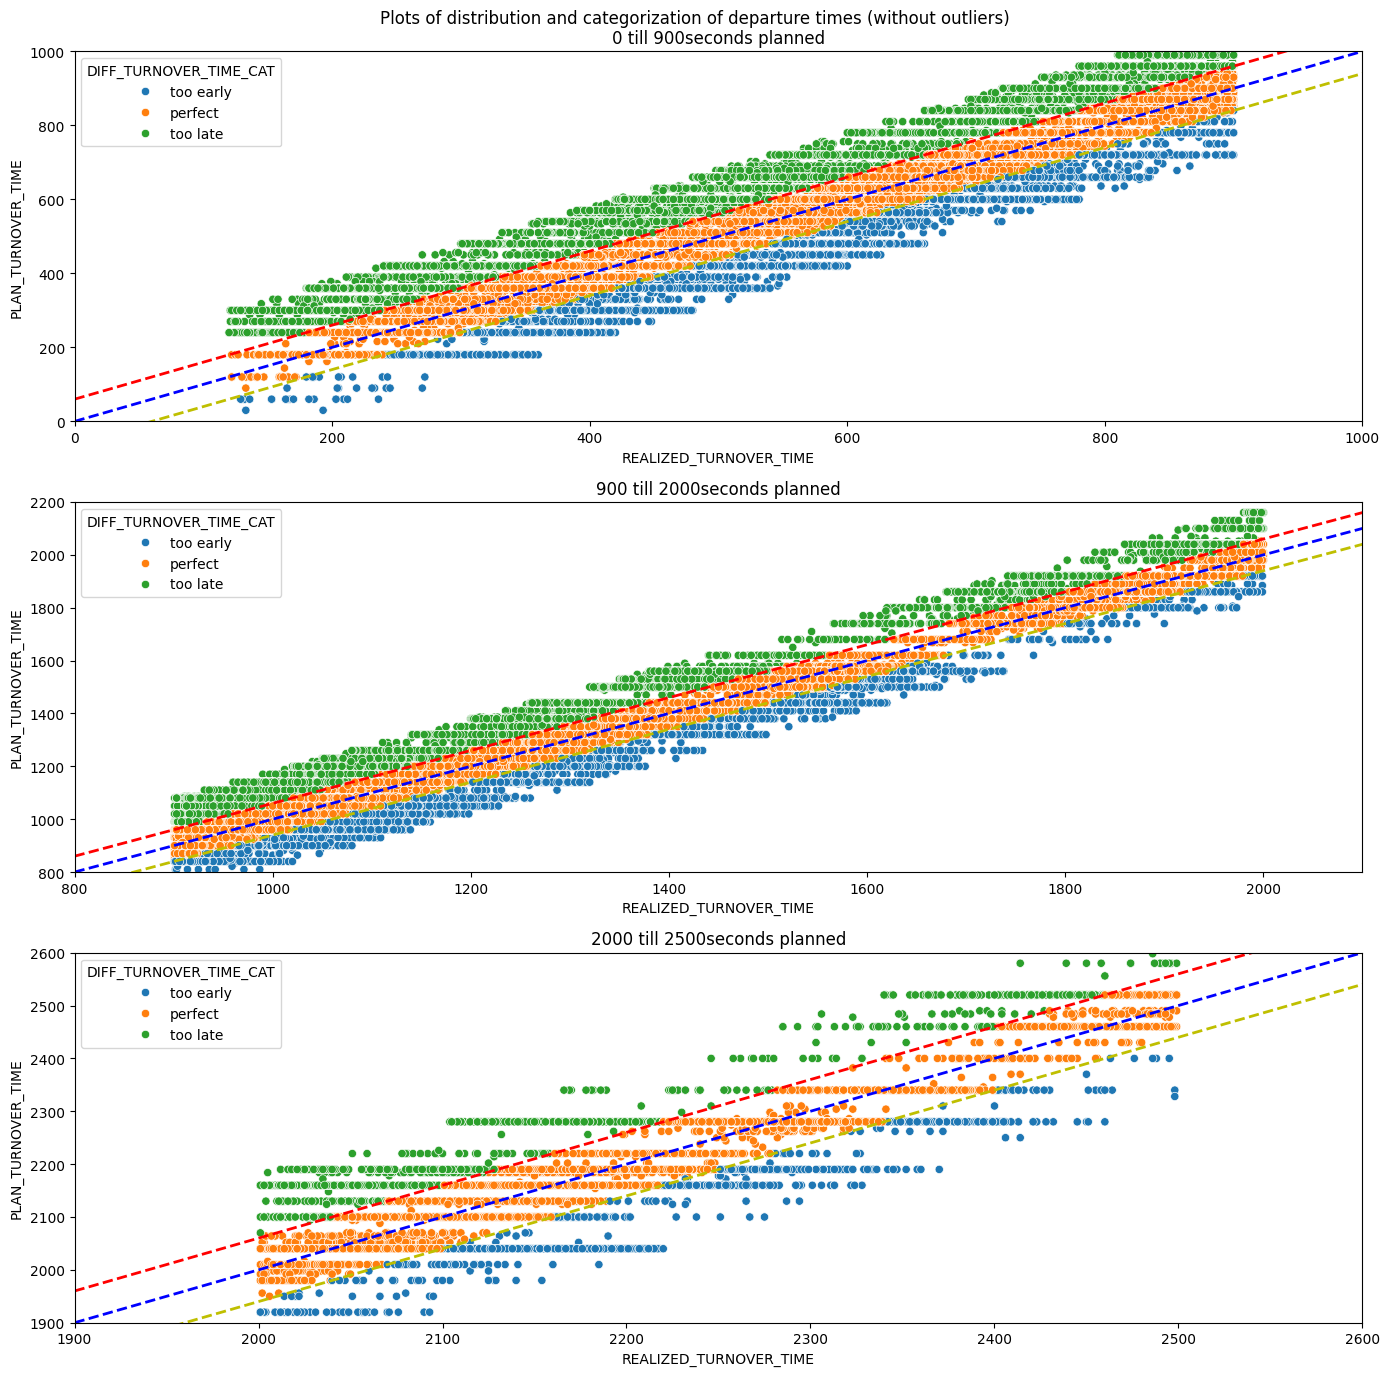

In [9]:
# Plots of Categorization of departure times
fig, (ax2, ax3, ax4) = plt.subplots(3,1, sharey = False, figsize=(14,14))
fig.suptitle('Plots of distribution and categorization of departure times (without outliers)')

# distribution of delay on realized_time plot
# whole picture
# sns.scatterplot(ax = ax1, data=df_complete, y='PLAN_TURNOVER_TIME', x='REALIZED_TURNOVER_TIME', hue='DIFF_TURNOVER_TIME_CAT', hue_order = hue_order[0:3])
# ax1.set_title('Whole distribution')
# ax1.set_xlim(0, 2500)
# ax1.set_ylim(0, 2500)
# zoomed in on 0-3000
sns.scatterplot(ax = ax2, data=df_0_900, y='PLAN_TURNOVER_TIME', x='REALIZED_TURNOVER_TIME', hue='DIFF_TURNOVER_TIME_CAT', hue_order = hue_order[0:3])
ax2.set_xlim(0, 1000)
ax2.set_ylim(0, 1000)
ax2.set_title('0 till 900seconds planned')
# zoomed in on 0-1000
sns.scatterplot(ax = ax3, data=df_900_2000, y='PLAN_TURNOVER_TIME', x='REALIZED_TURNOVER_TIME', hue='DIFF_TURNOVER_TIME_CAT', hue_order = hue_order[0:3])
ax3.set_title('900 till 2000seconds planned')
ax3.set_xlim(800, 2100)
ax3.set_ylim(800, 2200)

sns.scatterplot(ax = ax4, data=df_2000_2500, y='PLAN_TURNOVER_TIME', x='REALIZED_TURNOVER_TIME', hue='DIFF_TURNOVER_TIME_CAT', hue_order = hue_order[0:3])
ax4.set_title('2000 till 2500seconds planned')
ax4.set_xlim(1900, 2600)
ax4.set_ylim(1900, 2600)

# loop through plot-axis to draw divider lines
for item in [ax2, ax3, ax4]:
  # Get limits of item x and y axis
  xlim = item.get_xlim()
  ylim = item.get_ylim()

  # Set the limits of x and y axis to be the same to maintain aspect ratio
  lim = (min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
  # add diagonal line to plot
  lim_minus60 = (min(xlim[0] -60, ylim[0] -60), max(xlim[1] -60, ylim[1] -60))
  lim_plus60 = (min(xlim[0] +60, ylim[0] +60), max(xlim[1] +60, ylim[1] +60))


  # Draw a diagonal line from (min, min) to (max, max)
  item.plot(lim, lim, 'b--', lw=2) 
  item.plot(lim, lim_minus60, 'y--', lw=2) 
  item.plot(lim, lim_plus60, 'r--', lw=2) 

plt.tight_layout()

### Class distribution

In [4]:
hue_order = ['too early', 'perfect', 'too late']

class_count_complete = df_complete['DIFF_TURNOVER_TIME_CAT'].value_counts()
class_count_0_900 = df_0_900['DIFF_TURNOVER_TIME_CAT'].value_counts()
class_count_900_2000 = df_900_2000['DIFF_TURNOVER_TIME_CAT'].value_counts()
class_count_2000_2500 = df_2000_2500['DIFF_TURNOVER_TIME_CAT'].value_counts()

print(f"""
class count complete: {class_count_complete}
class count 0-900: {class_count_0_900}
class count 900-2000: {class_count_900_2000}
class count 2000-2500: {class_count_2000_2500}
""")


class count complete: DIFF_TURNOVER_TIME_CAT
perfect      183590
too late      33557
too early     19632
Name: count, dtype: int64
class count 0-900: DIFF_TURNOVER_TIME_CAT
perfect      99401
too late     21110
too early     9559
Name: count, dtype: int64
class count 900-2000: DIFF_TURNOVER_TIME_CAT
perfect      73029
too late     10743
too early     8699
Name: count, dtype: int64
class count 2000-2500: DIFF_TURNOVER_TIME_CAT
perfect      11160
too late      1704
too early     1374
Name: count, dtype: int64



Text(0.5, 1.0, 'Categorisation of planned turnover times')

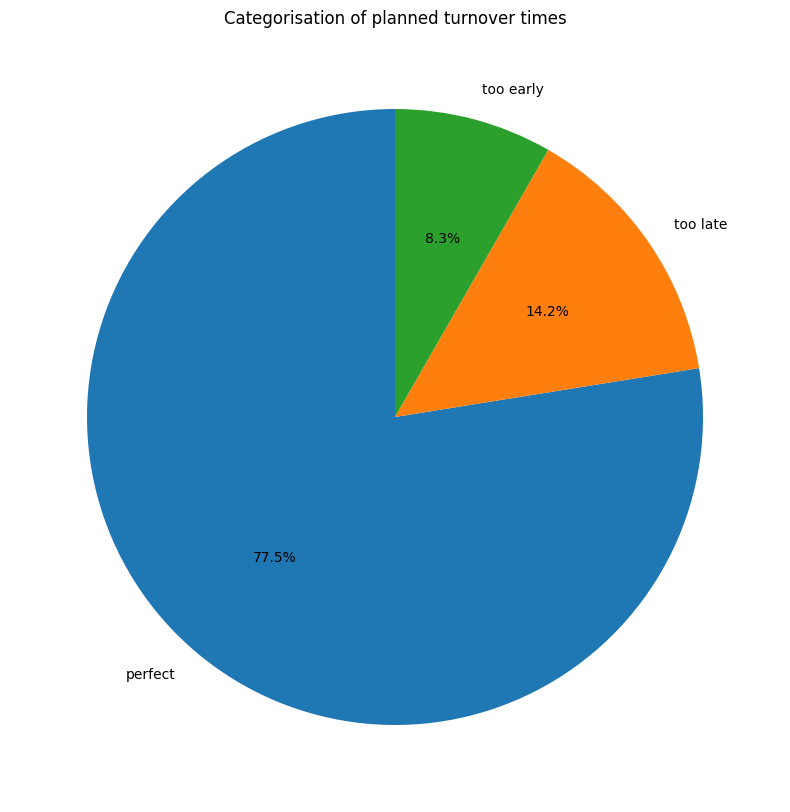

In [47]:

# Titles for each pie chart
titles = ['Categorisation of planned turnover times',
          '0-900 seconds',
          '900-2000 seconds',
          '2000-2500 seconds']

# Create a 2 by 2 grid of subplots
fig, axs = plt.subplots(figsize=(10, 10))

# Plot the first pie chart
plt.pie(class_count_complete, labels= class_count_complete.index, startangle = 90, autopct='%1.1f%%')
plt.title(titles[0])


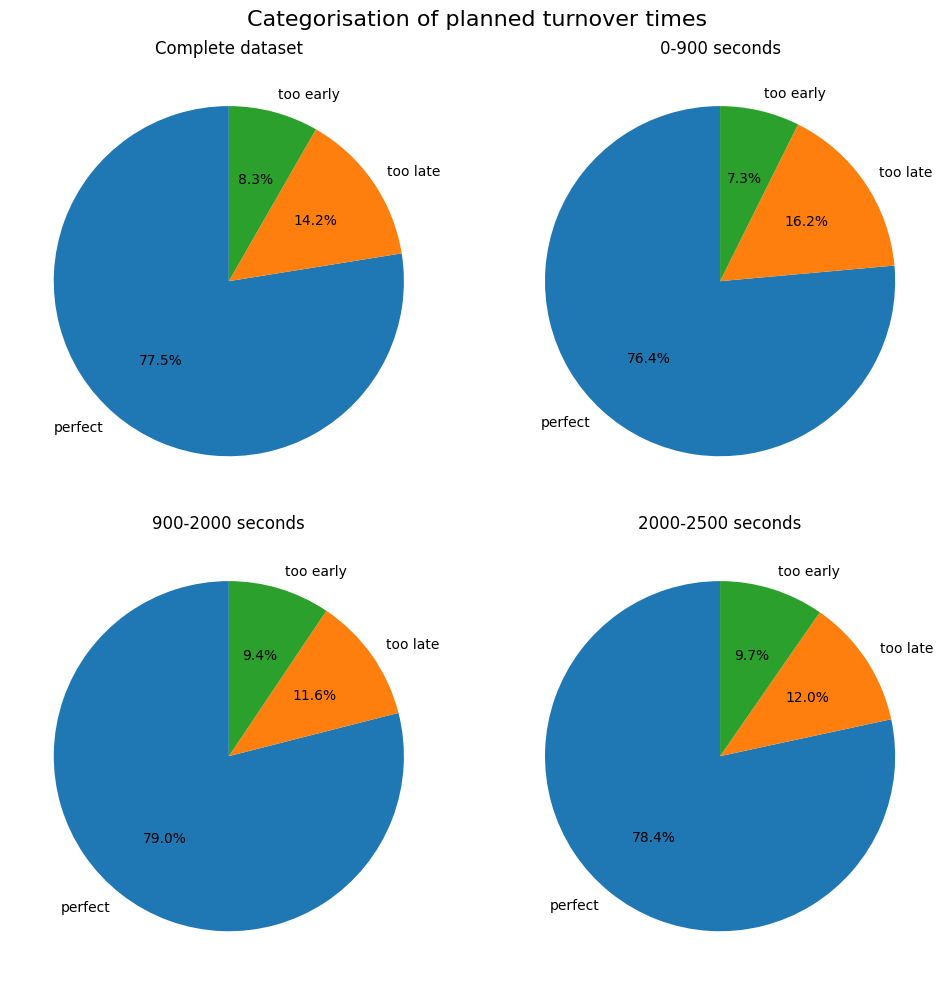

In [49]:
hue_order = ['too early', 'perfect', 'too late']


# Creating plot

# Titles for each pie chart
titles = ['Complete dataset',
          '0-900 seconds',
          '900-2000 seconds',
          '2000-2500 seconds']

# Create a 2 by 2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot the first pie chart
axs[0, 0].pie(class_count_complete, labels= class_count_complete.index, startangle = 90, autopct='%1.1f%%')
axs[0, 0].set_title(titles[0])

# Plot the second pie chart
axs[0, 1].pie(class_count_0_900, labels= class_count_complete.index, startangle = 90, autopct='%1.1f%%')
axs[0, 1].set_title(titles[1])

# Plot the third pie chart
axs[1, 0].pie(class_count_900_2000, labels= class_count_complete.index, startangle = 90, autopct='%1.1f%%')
axs[1, 0].set_title(titles[2])

# Plot the fourth pie chart
axs[1, 1].pie(class_count_2000_2500, labels= class_count_complete.index, startangle = 90, autopct='%1.1f%%')
axs[1, 1].set_title(titles[3])

# add title to the whole plot
fig.suptitle('Categorisation of planned turnover times', fontsize=16)
# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

